In [2]:
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
#NLP tools

import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
import gensim.downloader as api
from gensim.models import KeyedVectors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, paired_euclidean_distances, euclidean_distances, l
from  wordcloud import WordCloud, STOPWORDS

In [3]:
os.getcwd()

'c:\\Users\\arunk\\Assignments\\ASSESSMENT COMPLETION\\Machine_learning_Assessment'

In [4]:
json_data_path = r"Answer_3\News_Category_Dataset_v3.json"
df = pd.read_json(json_data_path,lines=True)

In [5]:
df.columns

Index(['link', 'headline', 'category', 'short_description', 'authors', 'date'], dtype='object')

In [6]:
df.head(2)

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23


In [7]:
df.nunique()

link                 209486
headline             207996
category                 42
short_description    187022
authors               29169
date                   3890
dtype: int64

In [8]:
df.describe()

,date
count,209527
mean,2015-04-30 00:44:14.344308736
min,2012-01-28 00:00:00
25%,2013-08-10 00:00:00
50%,2015-03-16 00:00:00
75%,2016-11-01 00:00:00
max,2022-09-23 00:00:00


In [9]:
df.shape

(209527, 6)

In [10]:
list(df)

['link', 'headline', 'category', 'short_description', 'authors', 'date']

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.6+ MB


In [12]:
#Checking for duplicates
dup=df.duplicated().sum()
print(f"The dataset contains {dup} duplicates which can be easliy dropped")
# drop_duplicates
if  dup:
    df=df.drop_duplicates()

assert df.duplicated().sum()==0

The dataset contains 13 duplicates which can be easliy dropped


In [13]:
#Extracting recent news articles
news_df= df[df['date'] >= pd.Timestamp(2019,1,1)]

#Checking the shape
shape=news_df.shape
print(f"The shape of the dataset is:", shape)

The shape of the dataset is: (7523, 6)


#### a. What categories of news dominates our dataset?

In [14]:
#Extracting the categories and the values counts
cat = news_df.category.value_counts(normalize=True,sort=False)*1000
df_counts = cat.rename_axis("Unique_cat").to_frame('counts')
df_counts =  df_counts.reset_index()

In [15]:
#Plotting function visualize the categories of the news articles
def circular_bar(df, col_name, col_counts):
# initialize the figure
    plt.figure(figsize=(15,20))
    ax = plt.subplot(111, polar=True)
    plt.axis('off')


# Set the coordinates limits
    upperLimit = 100
    lowerLimit = 40

    maxi = df[col_counts].max()
    slope = (maxi - lowerLimit) / maxi
    heights = slope * df[col_counts] + lowerLimit



# Compute the width of each bar. In total we have 2*Pi = 360°
    width = 2*np.pi / len(df.index)

# Compute the angle each bar is centered on:
    indexes = list(range(1, len(df.index)+1))
    angles = [element * width for element in indexes]
    angles
# Draw bars
    bars = ax.bar(
        x=angles, 
        height=heights, 
        width=width, 
        bottom=lowerLimit,
        linewidth=1, 
        edgecolor="black",
        color="#61a4b2",
    )

# little space between the bar and the label
    labelPadding = 4

# Add labels
    for bar, angle, height, label in zip(bars,angles, heights, df[col_name]):

    # Labels are rotated. Rotation must be specified in degrees :(
        rotation = np.rad2deg(angle)

    # Flip some labels upside down
        alignment = ""
        if angle >= np.pi/2 and angle < 3*np.pi/2:
            alignment = "right"
            rotation = rotation + 180
        else: 
            alignment = "left"

    # Finally add the labels
        ax.text(
            x=angle, 
            y=lowerLimit + bar.get_height() + labelPadding, 
            s=label, 
            ha=alignment, 
            va='center', 
            rotation=rotation, 
            rotation_mode="anchor") 
    plt.show()

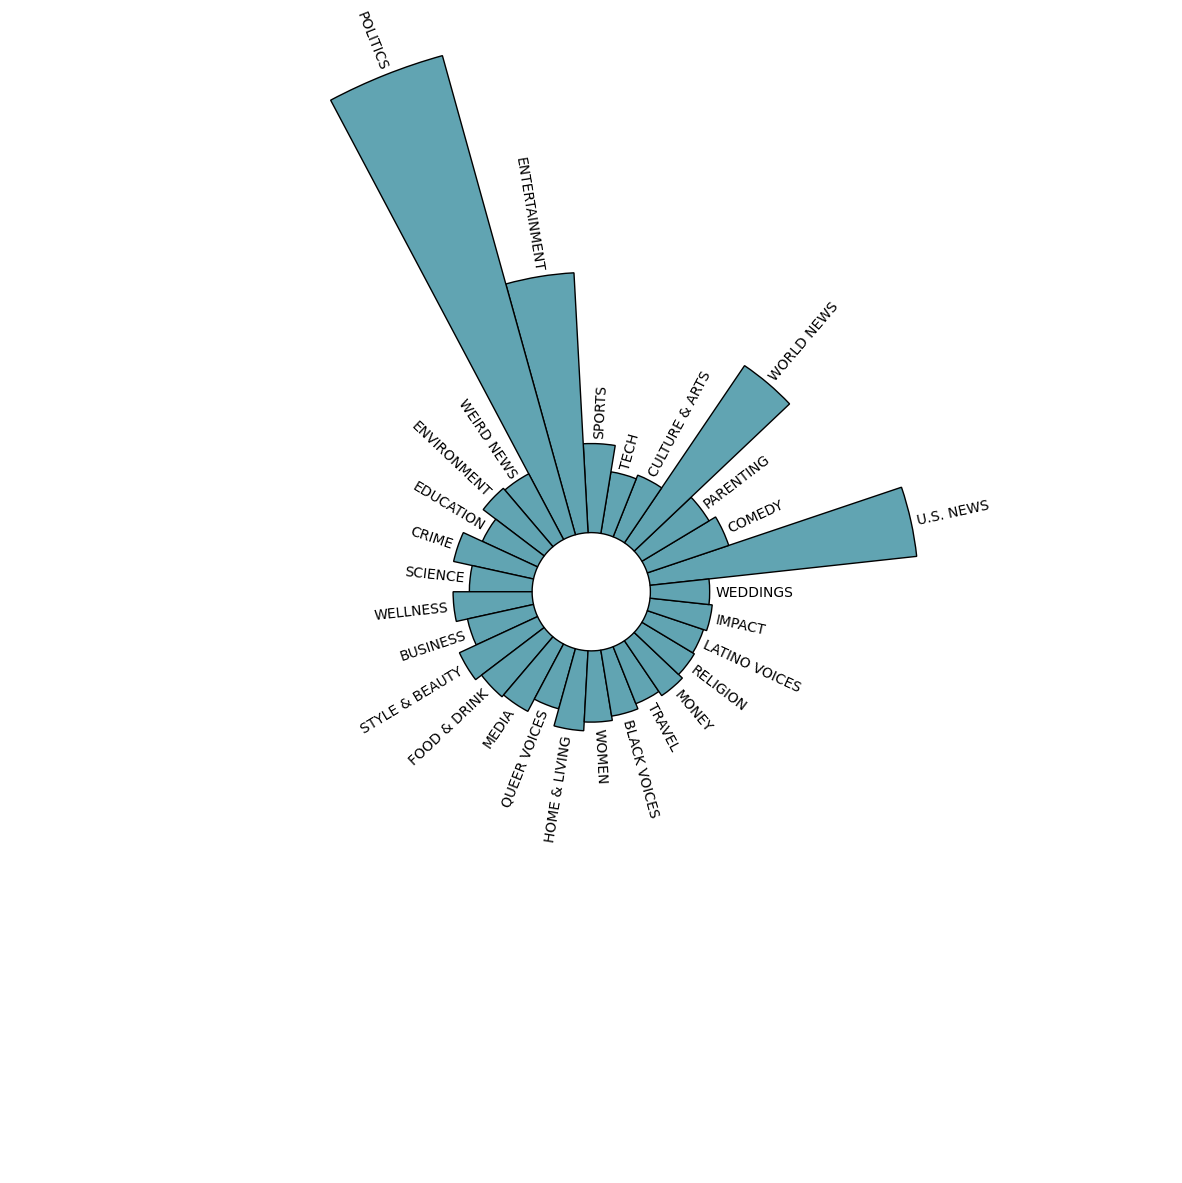

In [16]:
#Applying the function on the extracted category dataset
circular_bar(df_counts, 'Unique_cat', 'counts')

#### b. Checking out the news headlines

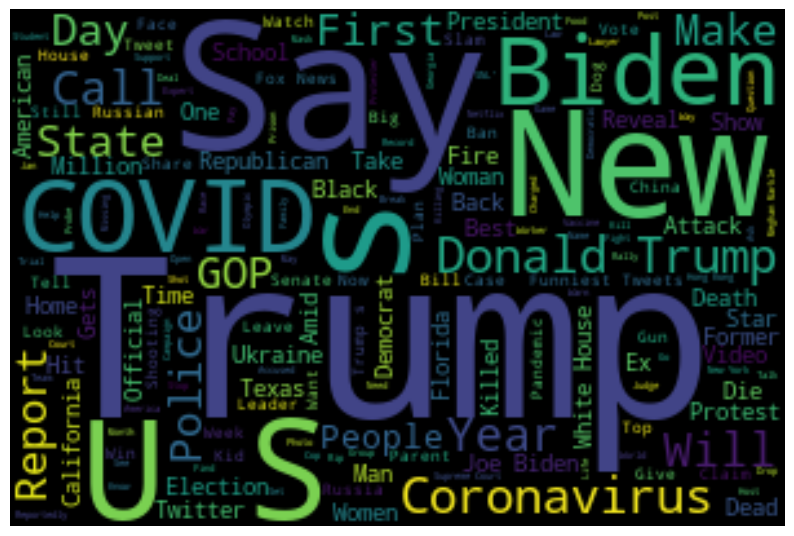

In [17]:
#Word cloud visualization
text=" ".join(i for i in news_df.headline)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 300, height = 200, stopwords=stopwords, background_color="black").generate(text)
plt.figure( figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
#plt.savefig("news1.png", format="png") 
plt.show()

 #### Text data Preprocessing

In [ ]:
news_df.head(2)

In [19]:
#Concatenating the headline and the short description column
news_df["news_text"] =news_df["headline"] + " " + news_df["short_description"] 

#Drop unnused columns from the dataset
news_df=news_df.drop(columns=["link", "authors", "category", "date", "short_description"])

en_stopwords =nltk.corpus.stopwords.words('english')
lemmatizer = WordNetLemmatizer()

#Defining th preprocessing function
def process(text):
    text = re.sub("[^A-Za-z1-9 ]", "", text)
    text = text.lower()
    tokens = word_tokenize(text)
    clean_list = []
    for token in tokens:
        if token not in en_stopwords:
            clean_list.append(lemmatizer.lemmatize(token))
    return " ".join(clean_list)

C:\Users\arunk\AppData\Local\Temp\ipykernel_4992\2011496081.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_df["news_text"] =news_df["headline"] + " " + news_df["short_description"]


In [20]:
news_df.news_text = news_df.news_text.apply(process)

In [21]:
news_df.head(1)

,headline,news_text
0,Over 4 Million Americans Roll Up Sleeves For O...,4 million american roll sleeve omicrontargeted...


##### TF-IDF with Cosine Similarity model

In [22]:
vectorizer = TfidfVectorizer()
features   = vectorizer.fit_transform(news_df['news_text'])

#Taking the cosine similarity of the vectorized text
cosine_sim = cosine_similarity(features,features)
euclidean_sim = euclidean_distances(features,features)

In [34]:
def get_recommended(headline_index, cosine_sim):
    headline=news_df.headline[headline_index]
    indices = pd.Series(news_df.index, index=news_df['headline']).drop_duplicates()
    # Get index of the news headline
    idx = indices[headline]
    print(idx)
    # Sort the news headline on the similarity scores
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Get the scores for 10 most similar news headlines
    sim_scores = sim_scores[1:11]
    # Get the headline indices
    scores=[i[1] for i in sim_scores]
    news_indices = [i[0] for i in sim_scores]
    # Return the top 10 most similar news headlines
    dfs=pd.DataFrame({'headlines': news_df['headline'].iloc[news_indices],
                'Cosine_similarity':  scores})
    print("*" * 30 + " News Recommendation " + "*" * 30)
    print("")
    print(f"News Headline: {headline}")
    print("")
    print( "*" * 29 + " Recommended News Articles " + "*" * 29)
    return dfs.iloc[0:,]

In [35]:
news_df.headline[44]
recommended=get_recommended(44, cosine_sim)
recommended

44
****************************** News Recommendation ******************************

News Headline: Mark Meadows Complies With Justice Dept. Subpoena: Report

***************************** Recommended News Articles *****************************


,headlines,Cosine_similarity
763,Mark Meadows Says Jan. 6 Panel Leaked Texts To...,0.309251
1485,House Moves Forward With Criminal Charges Agai...,0.296283
3988,Trump Went Through 'Very Concerning' Period Af...,0.262066
1509,Mark Meadows Hands Over PowerPoint Plan For Tr...,0.260786
1337,Laura Ingraham Feared More Violence After Jan....,0.232550
3804,North Carolina Republican Madison Cawthorn Wil...,0.229654
1465,Michael Cohen Slams 'Stupid' Mark Meadows On M...,0.205980
1449,Judge Denies Michael Flynn's Attempt To Block ...,0.193740
766,Samantha Bee Stunned By 'Gossipy Little Bitch'...,0.193017
862,DOJ Denies Jan. 6 Panel Details In Trump Recor...,0.179859


##### Word2Vec embedding with Cosine Similarity

In [26]:
from sklearn.metrics import jaccard_score ,euclidean_distances, pairwise_distances



# Euclidean distance
euclidean_distance = pairwise_distances(features, metric='euclidean')

# Levenshtein distance
# levenshtein_distance = nltk.edit_distance(features,features)


TypeError: sparse matrix length is ambiguous; use getnnz() or shape[0]